In [9]:
import zipfile
import os
import urllib.request
from datetime import datetime, timedelta
import pandas as pd

import warnings

warnings.filterwarnings("ignore")


def eventdf_FE(eventdf, CAMEOtags):
    """Filter the giant day GDELT event data to its relevant columns"""
    df = eventdf[
        [
            "SQLDATE",
            "IsRootEvent",
            "EventCode"
            # ,'QuadClass'           # Excluded as we build the event indices proposed by the paper
            # ,'GoldsteinScale'
            ,
            "ActionGeo_CountryCode",
            "SOURCEURL",  # As we are going to agregate all these for a month, it is not relevant anymore to track it back
        ]
    ].copy()
    # Extract only root events as done in the paper
    df = df[df["IsRootEvent"] == 1]
    df = df.drop("IsRootEvent", axis=1)
    # Extract only the relevant events
    df = df[df["EventCode"].isin(CAMEOtags)]
    # drop NaNs, as they are mostly in the CountryCode
    df = df.dropna()
    df = df.reset_index(drop=True)
    df = df.rename(
        columns={
            "SQLDATE": "date",
            "EventCode": "code",
            "ActionGeo_CountryCode": "country",
        }
    )
    return df


def get_category_weights(eventdf, CAMEO_weights):
    """Get the aggregated weights for each of the 5 event categories for each country
    as described in the paper, for a day"""
    df = eventdf_FE(eventdf, CAMEO_weights.index.tolist())
    # Aggregate them by country and event-type-code
    # and get the quantity of the single event-types for in each country
    df = df.groupby(["country", "code"]).size()
    df = pd.DataFrame(df).reset_index().rename(columns={0: "count"})
    # Now we are associating each event-type to their corresponding
    # weights and labels describe in the CAMEO_weights reference table
    df["category"] = pd.NA
    for i, row in df.loc[:, ["code"]].iterrows():
        weight = CAMEO_weights.loc[row["code"]]["weight"]
        count = df["count"].iloc[i]
        df["count"].iloc[i] = count * weight / 3
        df["category"].iloc[i] = CAMEO_weights.loc[row["code"]]["label"]
    # Done this, we don't need the code column anymore
    # so we drop it, an agreggate by country and category
    df = df.drop("code", axis=1).groupby(["country", "category"]).sum()
    return df


def extract_csv_from_zip(url, target_folder):
    try:
        # Download the zip file
        zip_file_path = os.path.join(target_folder, "data.zip")
        urllib.request.urlretrieve(url, zip_file_path)

        # Extract the CSV file from the zip
        with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
            csv_filename = zip_ref.namelist()[0]  # Assuming only one file in the zip
            csv_file_path = os.path.join(target_folder, csv_filename)
            zip_ref.extract(csv_filename, target_folder)

        # Delete the zip file
        os.remove(zip_file_path)

        return csv_file_path

    except urllib.error.HTTPError as e:
        if e.code == 404:
            return None


def process_gdelt_data(end_date, target_folder, header, verbose=False):
    """This function:
    1.Scrapes the daily events-zip files from the GDELT web
    2.Extracts the csvs from the zips
    3.Filters, aggregates and preprocess the data in the csv's
    4.Leaves only the already preprocessed csv's in the hard disk
      ready to be aggregated per month so they can be added in the model
    """
    delta = timedelta(days=1)  # Increment of one day
    missing_dates = []

    sqldate = end_date.strftime("%Y%m%d")
    url = f"http://data.gdeltproject.org/events/{sqldate}.export.CSV.zip"
    csv_file_path = extract_csv_from_zip(url, target_folder)

    # Checking if its a missing date
    if csv_file_path == None:
        print(f"URL for SQLDATE {sqldate} does not exist. Skipping.")
        missing_dates.append(sqldate)
        end_date -= delta

    elif verbose:
        print(f"File for SQLDATE {sqldate} extracted successfully.")

    # Read CSV file into DataFrame
    df = pd.read_table(csv_file_path, names=header, dtype={"EventCode": str})

    return df

In [21]:
header = "GLOBALEVENTID   SQLDATE MonthYear   Year    FractionDate	Actor1Code	Actor1Name	Actor1CountryCode	Actor1KnownGroupCode	Actor1EthnicCode	Actor1Religion1Code	Actor1Religion2Code	Actor1Type1Code	Actor1Type2Code	Actor1Type3Code	Actor2Code	Actor2Name	Actor2CountryCode	Actor2KnownGroupCode	Actor2EthnicCode	Actor2Religion1Code	Actor2Religion2Code	Actor2Type1Code	Actor2Type2Code	Actor2Type3Code	IsRootEvent	EventCode	EventBaseCode	EventRootCode	QuadClass	GoldsteinScale	NumMentions	NumSources	NumArticles	AvgTone	Actor1Geo_Type	Actor1Geo_FullName	Actor1Geo_CountryCode	Actor1Geo_ADM1Code	Actor1Geo_Lat	Actor1Geo_Long	Actor1Geo_FeatureID	Actor2Geo_Type	Actor2Geo_FullName	Actor2Geo_CountryCode	Actor2Geo_ADM1Code	Actor2Geo_Lat	Actor2Geo_Long	Actor2Geo_FeatureID	ActionGeo_Type	ActionGeo_FullName	ActionGeo_CountryCode	ActionGeo_ADM1Code	ActionGeo_Lat	ActionGeo_Long	ActionGeo_FeatureID	DATEADDED	SOURCEURL"
header = header.split()
CAMEO_weights = pd.read_csv(
    "../data/CAMEO_weights.csv", index_col=0, dtype={"code": str}
)
CAMEO_weights = CAMEO_weights.set_index("code").drop("description", axis=1)

start_date = datetime.strptime("20150101", "%Y%m%d")
# end_date = datetime.now() - timedelta(days=1)   # Uses the date of yesterday as the date
end_date = datetime.strptime("20230415", "%Y%m%d")
target_folder = "../data/gdelt_data/"

df = process_gdelt_data(end_date, target_folder, header, verbose=False)
df

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,1095869198,20130417,201304,2013,2013.2932,JUD,ADVOCATE,NaN,NaN,NaN,...,NaN,1,United States,US,US,39.828175,-98.5795,US,20230415,https://redstate.com/bobhoge/2023/04/14/mike-p...
1,1095869199,20220415,202204,2022,2022.2877,NaN,NaN,NaN,NaN,NaN,...,-655904,4,"Wuhan, Hubei, China",CH,CH12,30.583300,114.2670,-1930776,20230415,https://www.breitbart.com:443/national-securit...
2,1095869200,20220415,202204,2022,2022.2877,NaN,NaN,NaN,NaN,NaN,...,-655904,4,"Monumento, Estado do Rio, Brazil",BR,BR21,-22.718300,-43.8514,-655904,20230415,https://www.breitbart.com:443/national-securit...
3,1095869201,20220415,202204,2022,2022.2877,NaN,NaN,NaN,NaN,NaN,...,RS,1,Russia,RS,RS,60.000000,100.0000,RS,20230415,https://www.examiner.com.au/story/8159543/is-m...
4,1095869202,20220415,202204,2022,2022.2877,NaN,NaN,NaN,NaN,NaN,...,-2020890,4,"Niger Delta, Nigeria (general), Nigeria",NI,NI00,4.833330,6.0000,-2020890,20230415,https://www.nigeriasun.com/news/273745473/nige...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105283,1096031929,20230415,202304,2023,2023.2877,haw,HAWAIIAN,NaN,NaN,haw,...,HI,2,"Hawaii, United States",US,USHI,21.109800,-157.5310,HI,20230415,https://www.kitv.com/news/military-veterans-at...
105284,1096031930,20230415,202304,2023,2023.2877,idg,INDIGENOUS,NaN,NaN,idg,...,NaN,4,"Maningrida, Northern Territory, Australia",AS,AS03,-12.051100,134.2230,-1585602,20230415,https://www.skynews.com.au/australia-news/crim...
105285,1096031931,20230415,202304,2023,2023.2877,idg,INDIGENOUS,NaN,NaN,idg,...,NaN,5,"Northern Territory, Northern Territory, Australia",AS,AS03,-20.000000,134.0000,-1592100,20230415,https://www.skynews.com.au/australia-news/crim...
105286,1096031932,20230415,202304,2023,2023.2877,idg,INDIGENOUS,NaN,NaN,idg,...,-1585602,4,"Maningrida, Northern Territory, Australia",AS,AS03,-12.051100,134.2230,-1585602,20230415,https://www.skynews.com.au/australia-news/crim...


In [22]:
sudan = eventdf_FE(df, CAMEO_weights.index.tolist())
sudan

,date,code,country,SOURCEURL
0,20220415,046,LE,https://dailyvoice.com/new-york/rye/obituaries...
1,20220415,046,US,https://dailyvoice.com/new-york/rye/obituaries...
2,20220415,190,US,https://www.kvnf.org/npr-news/2023-04-14/nyc-i...
3,20220415,046,CH,https://www.sierraleonetimes.com/news/27374523...
4,20220415,046,CH,https://www.sierraleonetimes.com/news/27374523...
...,...,...,...,...
19337,20230415,036,PK,https://airwaysmag.com/wizz-air-abu-dhabi-paki...
19338,20230415,036,PK,https://airwaysmag.com/wizz-air-abu-dhabi-paki...
19339,20230415,172,US,https://www.washingtontimes.com/news/2023/apr/...
19340,20230415,193,US,https://www.msn.com/en-us/news/crime/nh-teenag...


In [25]:
sudan[sudan["country"] == "SU"].reset_index().to_csv(
    "../data/gdelt_data/sudan_events_civilwar_outbrake.csv"
)

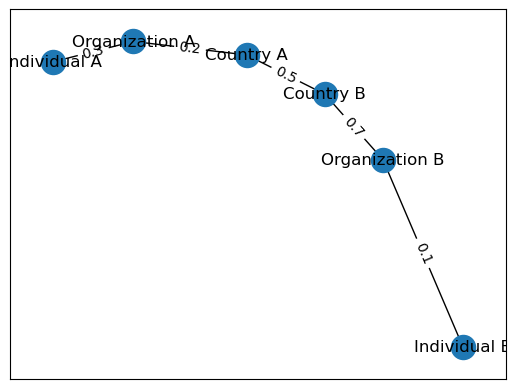

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# create a new graph
G = nx.Graph()

# add nodes for different actors
G.add_nodes_from(
    [
        "Country A",
        "Country B",
        "Organization A",
        "Organization B",
        "Individual A",
        "Individual B",
    ]
)

# add edges to represent relationships
G.add_edge("Country A", "Country B", weight=0.5)
G.add_edge("Country A", "Organization A", weight=0.2)
G.add_edge("Country B", "Organization B", weight=0.7)
G.add_edge("Organization A", "Individual A", weight=0.3)
G.add_edge("Organization B", "Individual B", weight=0.1)

# draw the graph
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the simulation parameters
num_agents = 50
num_iterations = 100
num_relationships = 100
num_countries = 10

# Initialize the simulation data
agent_positions = np.random.rand(num_agents, 2)
agent_velocities = np.random.rand(num_agents, 2)
agent_colors = np.random.rand(num_agents, 3)

relationship_matrix = np.zeros((num_countries, num_countries))
for i in range(num_relationships):
    country1 = np.random.randint(num_countries)
    country2 = np.random.randint(num_countries)
    relationship_matrix[country1, country2] = np.random.rand()

# Run the simulation
for i in range(num_iterations):
    # Update the agent positions based on their velocities
    agent_positions += agent_velocities

    # Update the agent velocities based on their relationships with other countries
    for j in range(num_countries):
        for k in range(num_countries):
            if relationship_matrix[j, k] > 0.5:
                # If countries j and k have a positive relationship, agents from those countries will move closer together
                j_agents = np.where(agent_countries == j)[0]
                k_agents = np.where(agent_countries == k)[0]
                for agent1 in j_agents:
                    for agent2 in k_agents:
                        separation = (
                            agent_positions[agent1, :] - agent_positions[agent2, :]
                        )
                        agent_velocities[agent1, :] -= (
                            separation * relationship_matrix[j, k]
                        )

    # Update the visualization
    plt.clf()
    plt.scatter(agent_positions[:, 0], agent_positions[:, 1], c=agent_colors)
    plt.pause(0.1)

# Analyze the simulation results and generate visualizations
# Write a report summarizing the simulation and its results

NameError: name 'agent_countries' is not defined

In [34]:
import pandas as pd

recognition_rate = pd.read_csv(
    "../data/recognition_rates_interpolated.csv"
    # The following arguments are essential to correctly read the data frame
    ,
    index_col=0,
    header=[0, 1],
)  # take the first to rows as headers/ horizontal multiindex

In [32]:
recognition_rate["VE"]["DE"]["2022-01":"2023-03"]

date
2022-01    145
2022-02    145
2022-03    185
2022-04    210
2022-05    140
2022-06    100
2022-07    150
2022-08    130
2022-09    125
2022-10     85
2022-11    180
2022-12    235
2023-01    455
2023-02    305
2023-03    395
Name: DE, dtype: int64